In [1]:
import numpy as np
import matplotlib.pyplot as plt
import welly
from welly import Project
import folium
import tensorflow as tf
from tensorflow import keras
import time

# Cargar el archivo LAS

In [2]:
palo761 = welly.read_las('/Users/Chemitas/Desktop/Desk/UNAM/ultimo_semestre/Procesamiento_datos/Pozos/datos/PALO BLANCO-791/PALO BLANCO 791_PROCESADO.las')
palo761

1it [00:00,  1.22it/s]


Index,UWI,Data,Curves
0,,39 curves,"M1R6, M1R9, CNCF, GR, CAL, SP, DPHI, VCL, PHIE, SW, BVW, KTIXIER, TVD, TVDSS, PAYFLAG, VPVS, POISDIN, MPERMC, MPOC01, T2_CUT_33, MPOC02, MPOC03, MPOC04, MPOC05, MPOC06, MPOC07, MPOC08, MPOC09, MPOC10, MPOC11, MPOC12, MPOC13, ECHADOS, FRAC_NAT, FRAC_IND, DTC, DTS, SPHI, ZDEN"


In [3]:
abedul = welly.read_las('/Users/Chemitas/Desktop/Desk/UNAM/ultimo_semestre/Geofisica_integral/Proyecto/Abedul/Originales/70449_abedul1_gn_1850_800_05mz79p.las')
abedul

1it [00:00,  2.23it/s]


Index,UWI,Data,Curves
0,1030022740,2 curves,"GR, NEUT"


# Cargar los registros de pozo

In [4]:
vpvs = palo761[0].data['VPVS']
dtc = palo761[0].data['DTC']
dts = palo761[0].data['DTS']
gr = palo761[0].data['GR']
echados = palo761[0].data['ECHADOS']
cali = palo761[0].data['CAL']
mpoc02 = palo761[0].data['MPOC02']
zden = palo761[0].data['ZDEN']
poisson = palo761[0].data['POISDIN']
print(len(gr.values))

6038


In [5]:
gr_a = abedul[0].data['GR']
print(type(gr_a))
gamma_a = np.array(gr_a)


<class 'welly.curve.Curve'>


# Cálculos

In [6]:
BI = -0.012 * dtc.values + 1.4921
E = zden.values * vpvs.values**2

In [7]:
type(BI)

numpy.ndarray

# Pre-procesamiento
## Remover valores NaN
## Sampleo para entrenar la red

In [8]:
ER = E[~np.isnan(E)]
BIR = BI[~np.isnan(BI)]
GR = gr.values[~np.isnan(gr.values)]

In [21]:
BI2 = []
E2 = []
GR2 = []
for i in range(5000):
    BI2.append(BIR[i])
    E2.append(ER[i])
    GR2.append(GR[i])

In [10]:
inicio = 550.0116
fin = 1470.0504
depth = np.linspace(inicio, fin, len(gr.values))

In [11]:
vd = (0.5 * (vpvs)**2 - 1)/((vpvs)**2 - 1)
vsh_linear = (gr - gr.min()) / (gr.max() - gr.min())
vsh_larinov = 1/3 * (2**(2*vsh_linear) - 1)
vsh_stieber = vsh_linear / (3 - 2*vsh_linear)

shale = sum(gr.values)

Text(0.5, 1.0, 'Vshale Stieber')

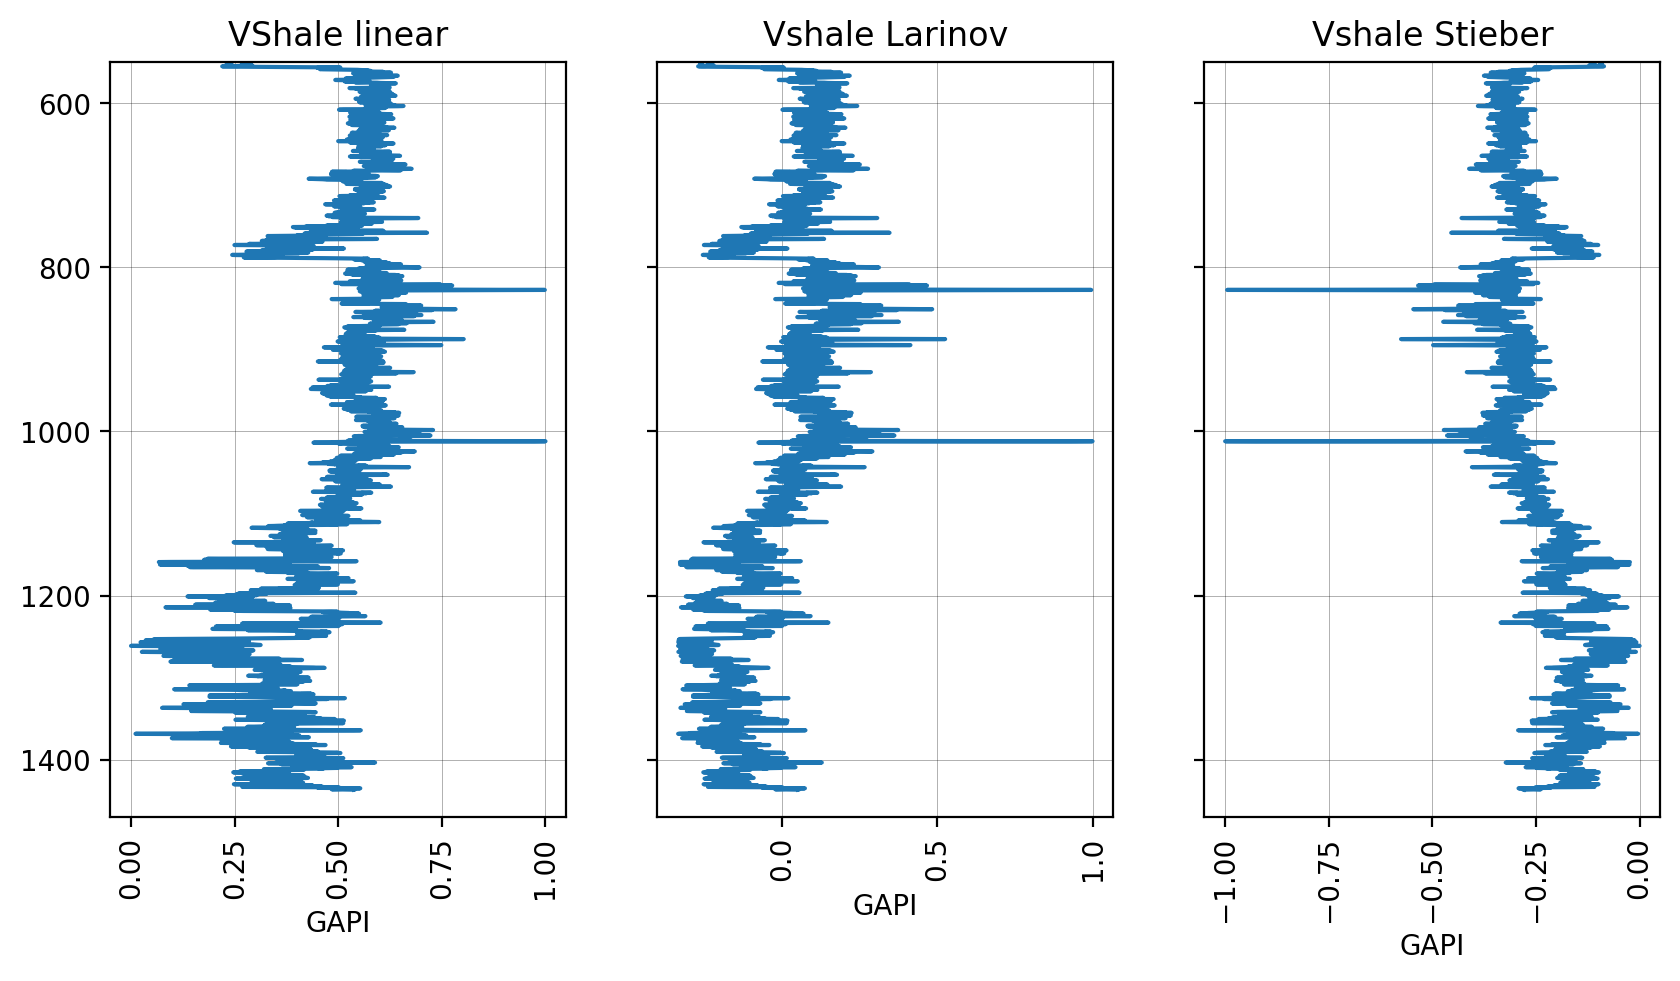

In [12]:
fig, ax = plt.subplots(1,3, figsize = (10,5), dpi = 200, sharey = True)
vsh_linear.plot(ax[0])
ax[0].set_title('VShale linear')

vsh_larinov.plot(ax[1])
ax[1].set_title('Vshale Larinov')

vsh_stieber.plot(ax[2])
ax[2].set_title('Vshale Stieber')


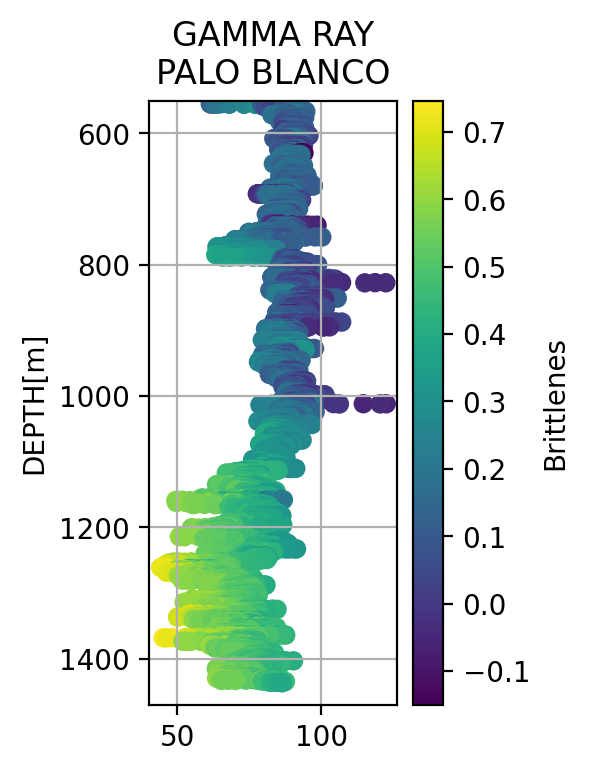

In [13]:
figure = plt.figure(figsize = (2,4), dpi = 200)
plt.scatter(gr.values, depth, c = BI, cmap = 'viridis')
plt.ylim(fin,inicio)
plt.title('GAMMA RAY\nPALO BLANCO')
plt.ylabel('DEPTH[m]')
plt.colorbar(label = 'Brittlenes')
plt.grid()
plt.savefig('res_gammaray.png', bbox_inches = 'tight')

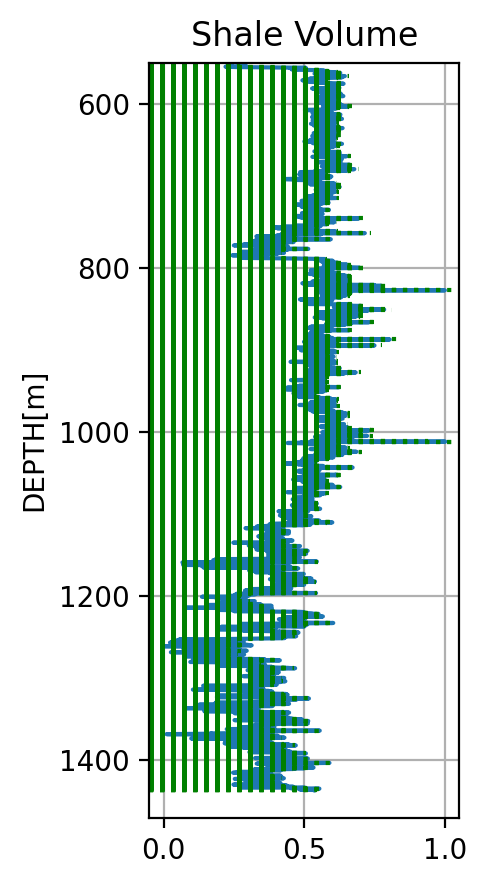

In [14]:
figure = plt.figure(figsize = (2,5), dpi = 200)
plt.plot(vsh_linear.values, depth)
for i in range(len(depth)):
    plt.axhline(depth[i], 0, vsh_linear.values[i], color = 'green', ls = ':')

plt.ylim(fin, inicio)
plt.title('Shale Volume')
plt.ylabel('DEPTH[m]')
plt.grid('--')

plt.savefig('volumen_arcilla.png', bbox_inches = 'tight')

In [15]:
vd

Curve(mnemonic=VPVS, units=ft/sec, start=550.0116, stop=1470.0504, step=0.1524, count=[5931])

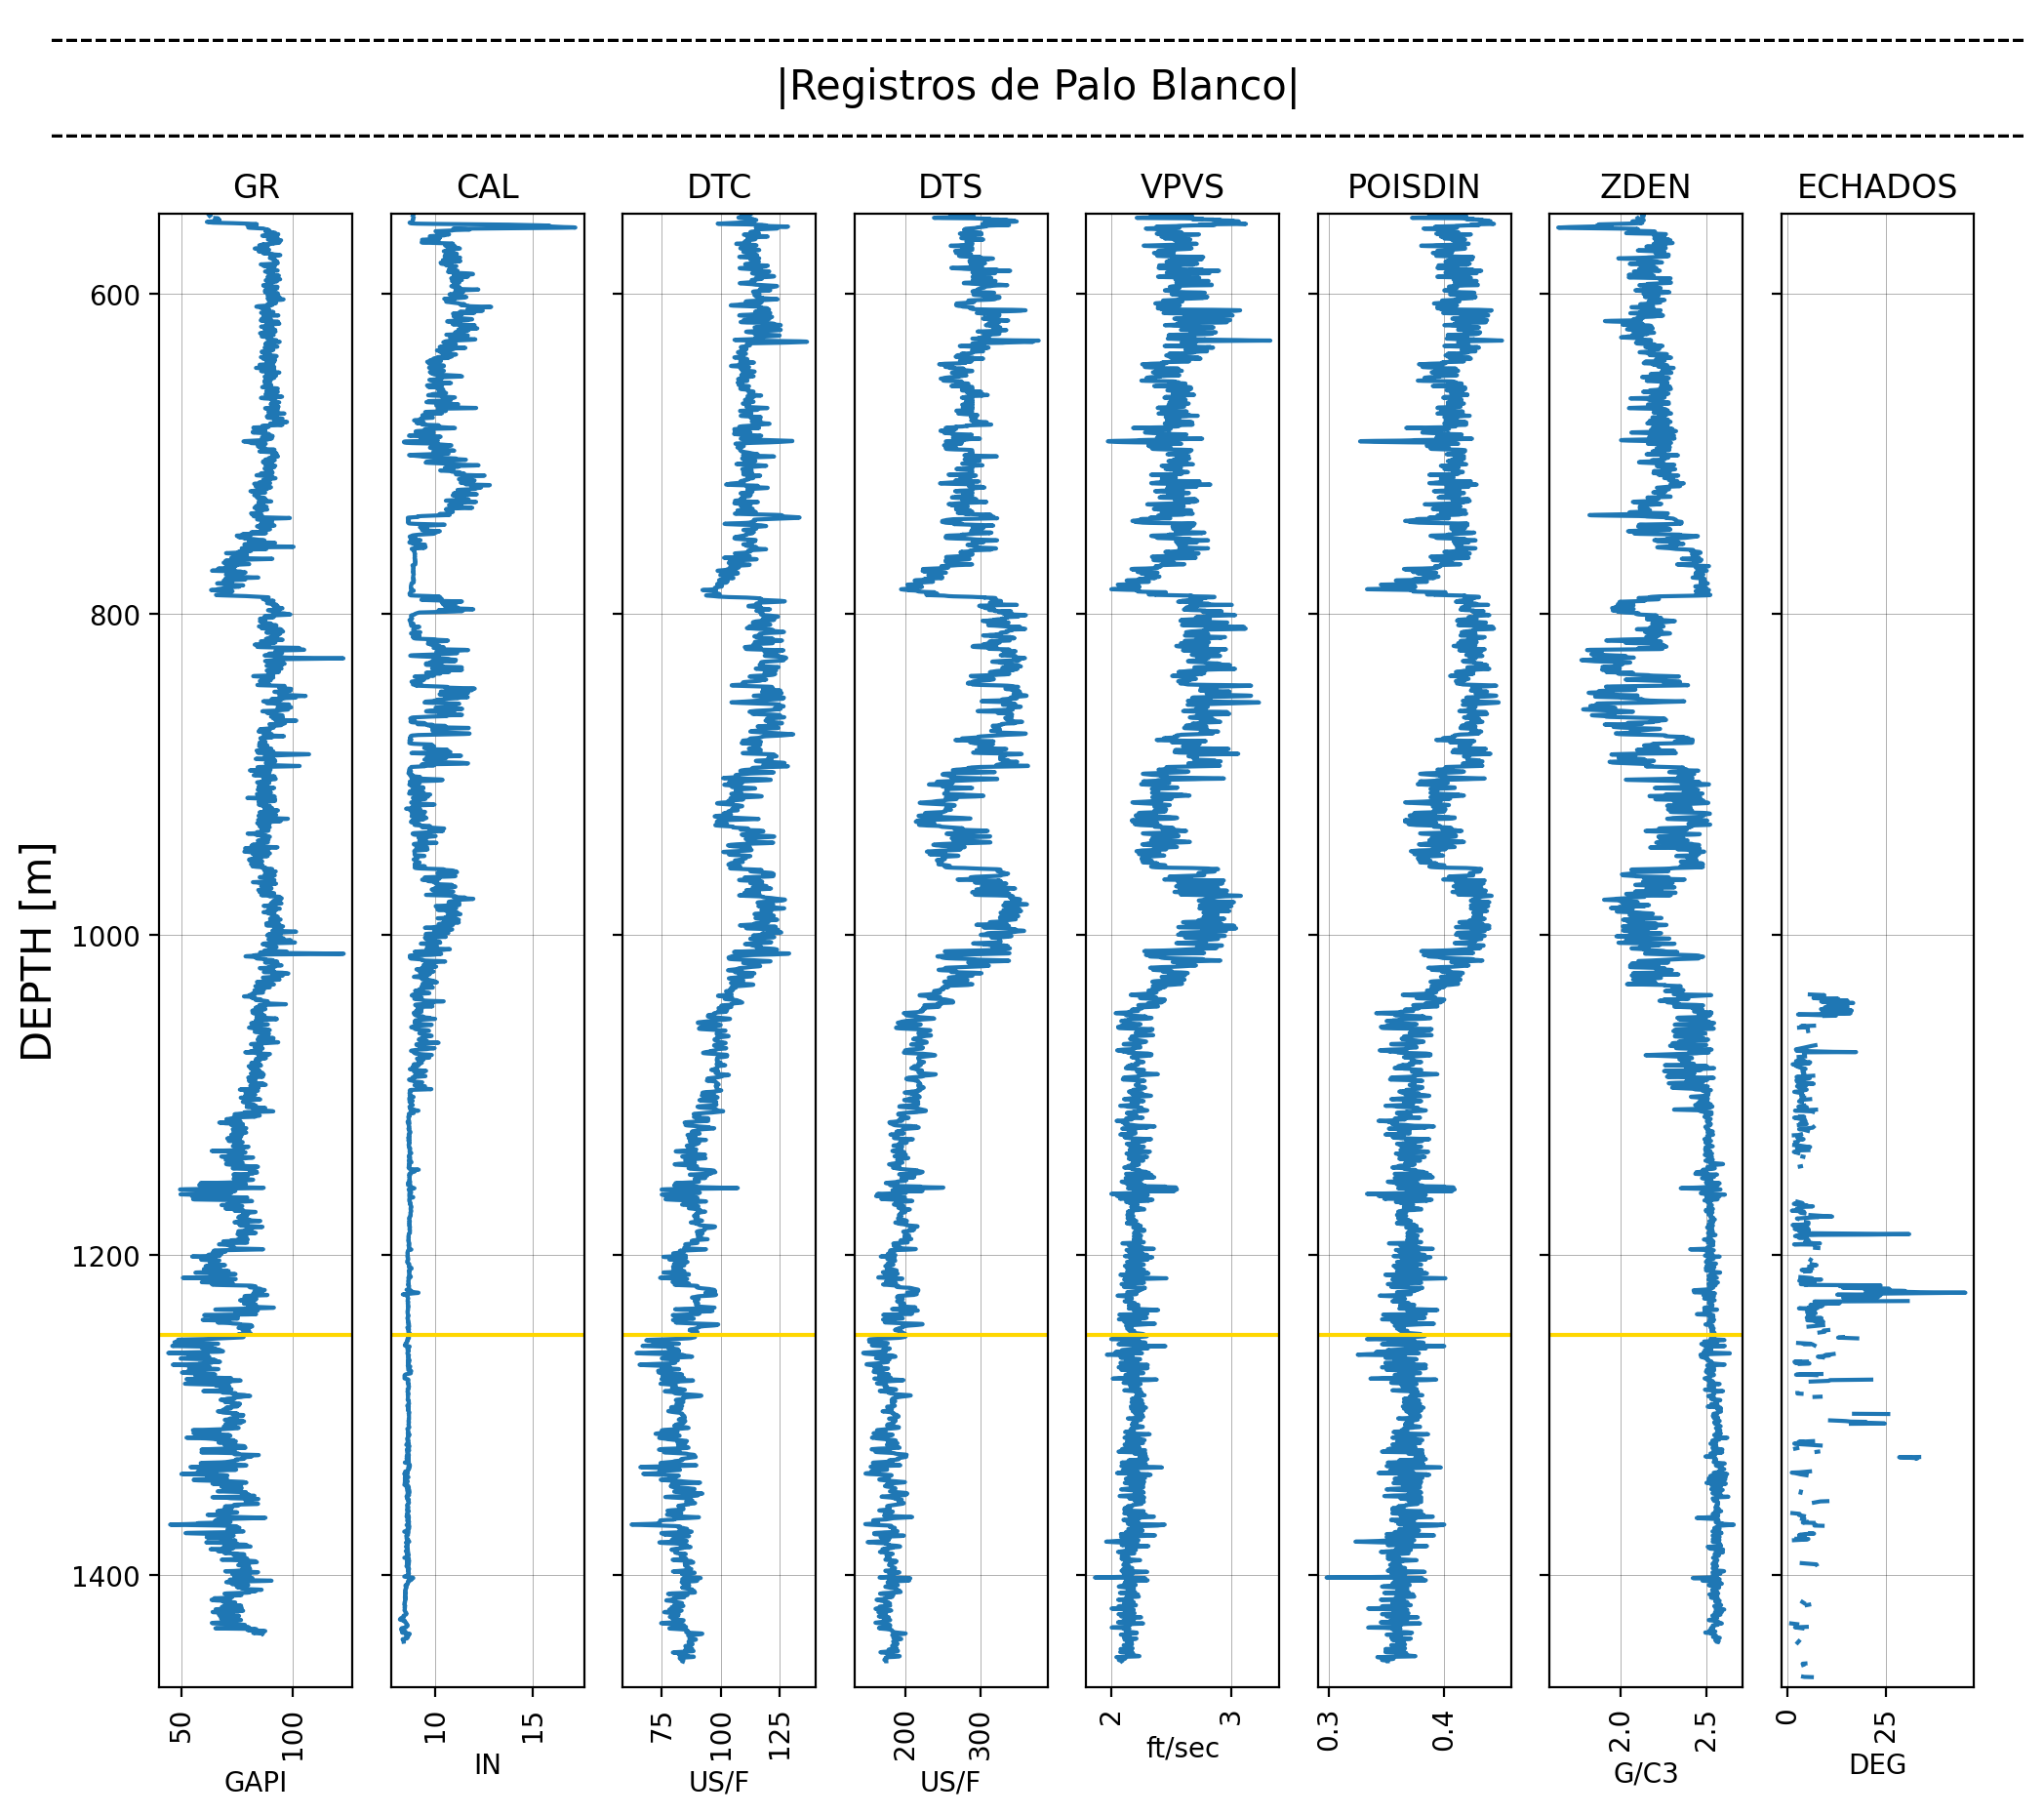

In [16]:
fig, ax = plt.subplots(1,8, figsize = (12,10), dpi = 200, sharey = True)

gr.plot(ax[0])
cali.plot(ax[1])
dtc.plot(ax[2])
dts.plot(ax[3], '--')
vpvs.plot(ax[4])
poisson.plot(ax[5])
zden.plot(ax[6])
echados.plot(ax[7])

ax[0].set_ylabel('DEPTH [m]', fontsize = 15)
for i in range(7):
    ax[i].axhline(1250, c = 'gold')
plt.suptitle('---------------------------------------------------------------------------------------------------------------------------------------\n'
             '|Registros de Palo Blanco|\n'
             '---------------------------------------------------------------------------------------------------------------------------------------\n'
            , fontsize = 15);
plt.savefig('reistros.png', bbox_inches = 'tight')

# Red neuronal
## Arquitectura
## Compilación
## Entrenamiento

In [17]:
capas = int(input('Capas para la red neuronal:\n '))
inputs = int(input('¿Cuántos datos de entrada recibira la red?:\n '))
C = []
for i in range(1,capas):
    ocultai = tf.keras.layers.Dense(units = capas, input_shape = [inputs])
    C.append(ocultai)
salida = tf.keras.layers.Dense(units = 1)
C.append(salida)
modelo = tf.keras.Sequential(C)

Capas para la red neuronal:
  10
¿Cuántos datos de entrada recibira la red?:
  1


In [18]:
modelo.compile(optimizer = tf.keras.optimizers.Adam(0.1),
             loss = 'mean_squared_error')

In [23]:
print("Entrenando el modelo...")
tic = time.time()
historial = modelo.fit(GR2, BI2, epochs=10, verbose=False)
toc = time.time()
print("Modelo entrenado en {} segundos".format(toc-tic))

Entrenando el modelo...
Modelo entrenado en 7.876457929611206 segundos


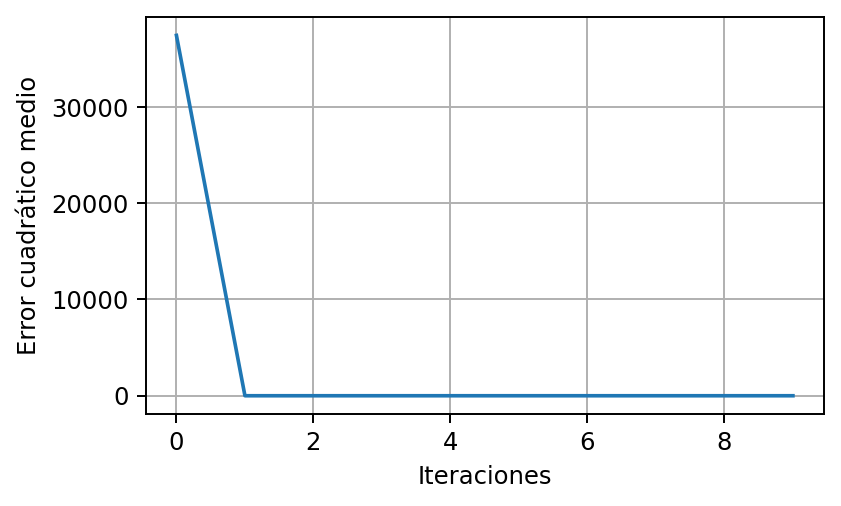

In [24]:
figure = plt.figure(figsize = (5,3), dpi = 175)
plt.plot(historial.history["loss"])
plt.xlabel("Iteraciones")
plt.ylabel("Error cuadrático medio")
plt.grid()
plt.savefig('error3.png', bbox_inches = 'tight')

In [25]:
historial.history["loss"]

[37432.46875,
 0.1643514186143875,
 0.11376471817493439,
 0.0718289390206337,
 0.043726399540901184,
 0.026595482602715492,
 0.018626518547534943,
 0.013822038657963276,
 0.013150026090443134,
 0.012058654800057411]

In [41]:
prediccion = modelo.predict(GR2)
print("Predicción de fragilidad:", prediccion)

157/157 [==============================] - 1s 5ms/step
Predicción de fragilidad: [[0.49497673]
 [0.48717973]
 [0.48397776]
 ...
 [0.38675234]
 [0.38074085]
 [0.3898122 ]]


In [71]:
i_fragilidad = prediccion
inicio = 550.0116
fin = 1470.0504
num_elementos = len(i_fragilidad)
depth = np.linspace(inicio, fin, num_elementos)
print(i_fragilidad)

[[0.49497673]
 [0.48717973]
 [0.48397776]
 ...
 [0.38675234]
 [0.38074085]
 [0.3898122 ]]


In [43]:
print(len(i_fragilidad), len(BI2))

5000 5000


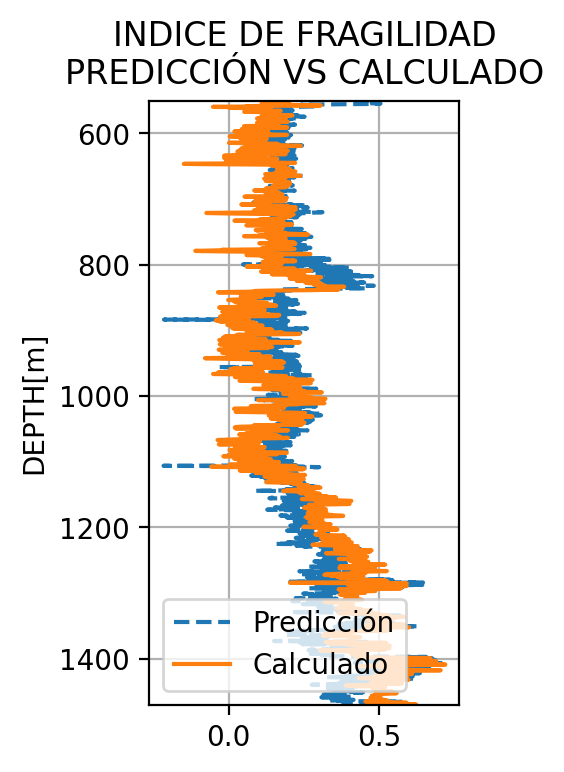

In [46]:
figure = plt.figure(figsize = (2,4), dpi = 200)
plt.plot(i_fragilidad, depth, '--', label = 'Predicción')
plt.plot(BI2, depth, label = 'Calculado')
plt.legend()
plt.grid()
plt.ylim(fin, inicio)
plt.ylabel('DEPTH[m]')
plt.title('INDICE DE FRAGILIDAD\nPREDICCIÓN VS CALCULADO')
plt.savefig('calculados_prediccion.png', bbox_inches = 'tight')

In [50]:
indice = []
for i in range(len(BI2)):
    indi = (BI2[i])/(i_fragilidad[i])
    indice.append(indi)

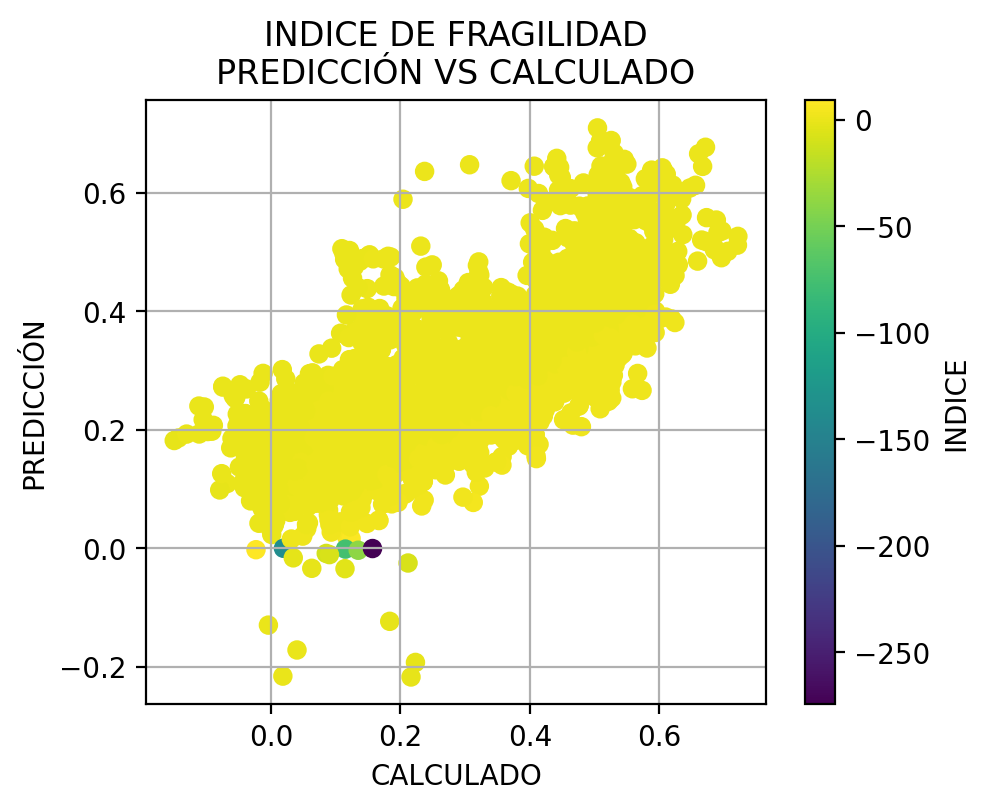

In [73]:
figure = plt.figure(figsize = (5,4), dpi = 200)
plt.scatter(BI2, i_fragilidad, c = indice, cmap = 'viridis')
plt.grid()
plt.ylabel('PREDICCIÓN')
plt.xlabel('CALCULADO')
plt.colorbar(label = 'INDICE')
plt.title('INDICE DE FRAGILIDAD\nPREDICCIÓN VS CALCULADO')
plt.savefig('rela.png', bbox_inches = 'tight')

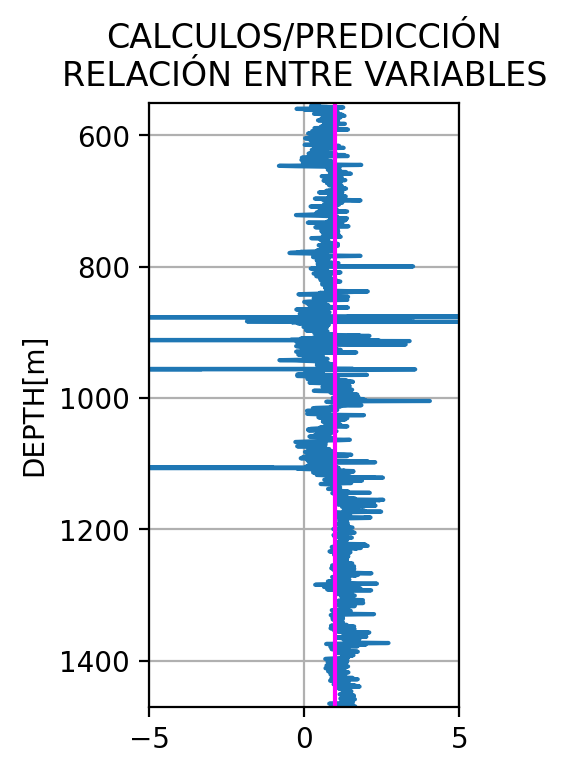

In [72]:
figure = plt.figure(figsize = (2,4), dpi = 200)
plt.plot(indice, depth);
plt.ylim(fin, inicio)
plt.grid()
plt.ylabel('DEPTH[m]')
plt.xlim(-5,5)
plt.axvline(x = 1, c = 'magenta')
plt.title('CALCULOS/PREDICCIÓN\nRELACIÓN ENTRE VARIABLES')
plt.savefig('indies.png', bbox_inches = 'tight')

In [53]:
palo_prediccion = modelo.predict(gr.values)
print("Predicción de fragilidad:", palo_prediccion)

189/189 [==============================] - 1s 6ms/step
Predicción de fragilidad: [[0.49497673]
 [0.48717973]
 [0.48397776]
 ...
 [       nan]
 [       nan]
 [       nan]]


In [63]:
print(len(GR), len(depth))
depth = np.linspace(inicio, fin, len(gr.values))
print(len(depth), len(palo_prediccion))

5811 6038
6038 6038


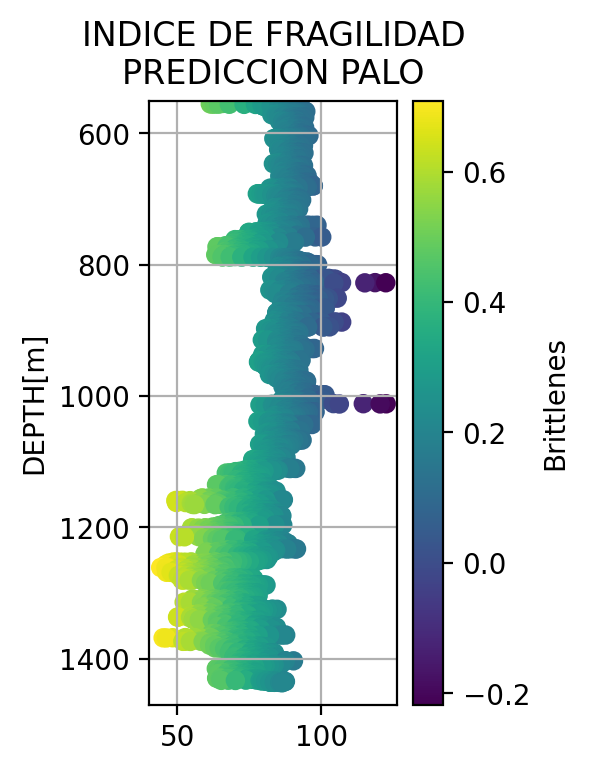

In [64]:
figure = plt.figure(figsize = (2,4), dpi = 200)
plt.scatter(gr.values, depth, c = palo_prediccion, cmap = 'viridis')
plt.ylim(fin,inicio)
plt.title('INDICE DE FRAGILIDAD\nPREDICCION PALO')
plt.ylabel('DEPTH[m]')
plt.colorbar(label = 'Brittlenes')
plt.grid()
plt.savefig('palo_prediccion.png', bbox_inches = 'tight')

In [65]:
abedul_prediccion = modelo.predict(gr_a.values)
print("Predicción de fragilidad:", abedul_prediccion)

216/216 [==============================] - 2s 7ms/step
Predicción de fragilidad: [[0.83814883]
 [0.83433414]
 [0.8304846 ]
 ...
 [1.0095922 ]
 [1.0024086 ]
 [0.99553657]]


In [66]:
gr_a

Curve(mnemonic=GR, units=GAPI, start=800.0000, stop=1849.5788, step=0.1524, count=[6888])

In [67]:
start = 800.0000
finish = 1849.5788
nele = len(gr_a.values)
prof2 = np.linspace(start, finish, nele)

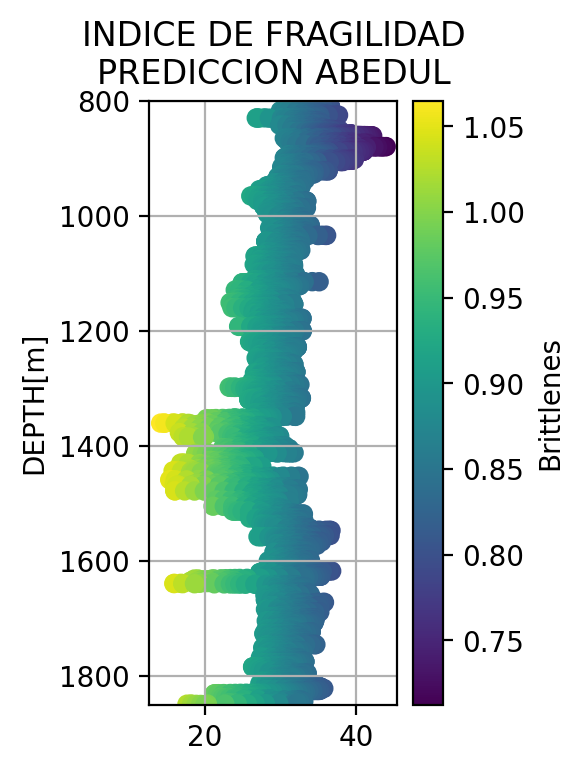

In [68]:
figure = plt.figure(figsize = (2,4), dpi = 200)
plt.scatter(gr_a.values, prof2, c = (abedul_prediccion), cmap = 'viridis')
plt.ylim(finish, start)
plt.grid()
plt.title('INDICE DE FRAGILIDAD\nPREDICCION ABEDUL')
plt.colorbar(label = 'Brittlenes')
plt.ylabel('DEPTH[m]')
plt.savefig('abedul_prediccion_color.png', bbox_inches = 'tight')

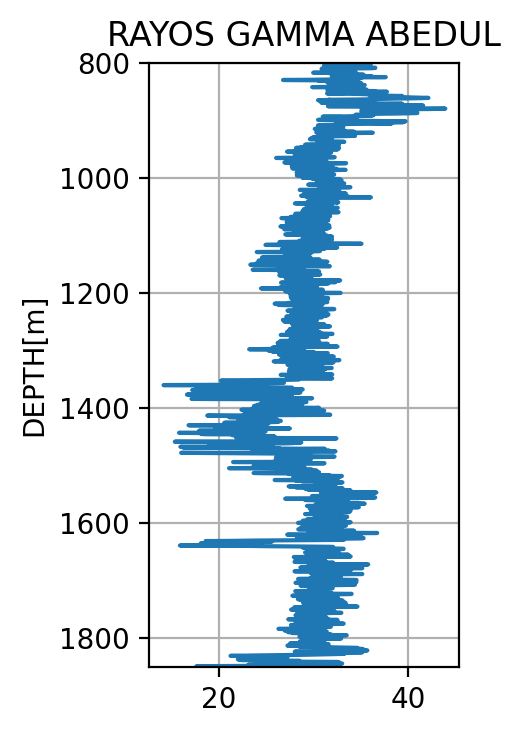

In [69]:
figure = plt.figure(figsize = (2,4), dpi = 200)
plt.plot(gr_a.values, prof2)
plt.ylim(finish, start)
plt.grid()
plt.title('RAYOS GAMMA ABEDUL')
plt.ylabel('DEPTH[m]')
plt.savefig('abedul_ggr.png', bbox_inches = 'tight')

In [111]:
pesos = []
for i in range(10):
    print('Peso{}--------------------'.format(i))
    pesos.append(ocultai.get_weights())
    print(ocultai.get_weights())

ypesos = np.arange(10)

Peso0--------------------
[array([[ 1.24202631e-01, -3.59083474e-01,  3.40929627e-01,
        -1.96172521e-01, -1.77778274e-01,  4.89329666e-01,
         4.25295055e-01, -1.51593864e-01, -3.55489790e-01,
         5.00988424e-01],
       [-7.38225728e-02, -3.14519018e-01,  1.19057667e+00,
         1.64120540e-01, -3.61496717e-01,  5.70957899e-01,
         1.80214062e-01, -5.37172705e-02,  4.55456614e-01,
        -7.71226883e-01],
       [-1.88983783e-01,  5.98129988e-01, -6.30938590e-01,
         1.50829419e-01,  1.34031191e-01,  1.44816905e-01,
         7.62443304e-01,  4.91613686e-01, -5.70339024e-01,
         1.10579801e+00],
       [ 3.42090458e-01,  6.34428579e-03,  2.01943889e-01,
        -3.35734874e-01, -2.17548594e-01,  1.20646536e-01,
        -1.53940782e-01,  1.54504731e-01,  2.67345011e-01,
        -1.84277326e-01],
       [-9.88426685e-01,  5.06064057e-01,  6.11299694e-01,
        -2.60011852e-01,  1.17703520e-01, -2.11158901e-01,
         7.35400558e-01,  3.26349407e-01, -

In [114]:
pesos[0][0][0]

array([ 0.12420263, -0.35908347,  0.34092963, -0.19617252, -0.17777827,
        0.48932967,  0.42529505, -0.15159386, -0.3554898 ,  0.5009884 ],
      dtype=float32)

IndexError: list index out of range

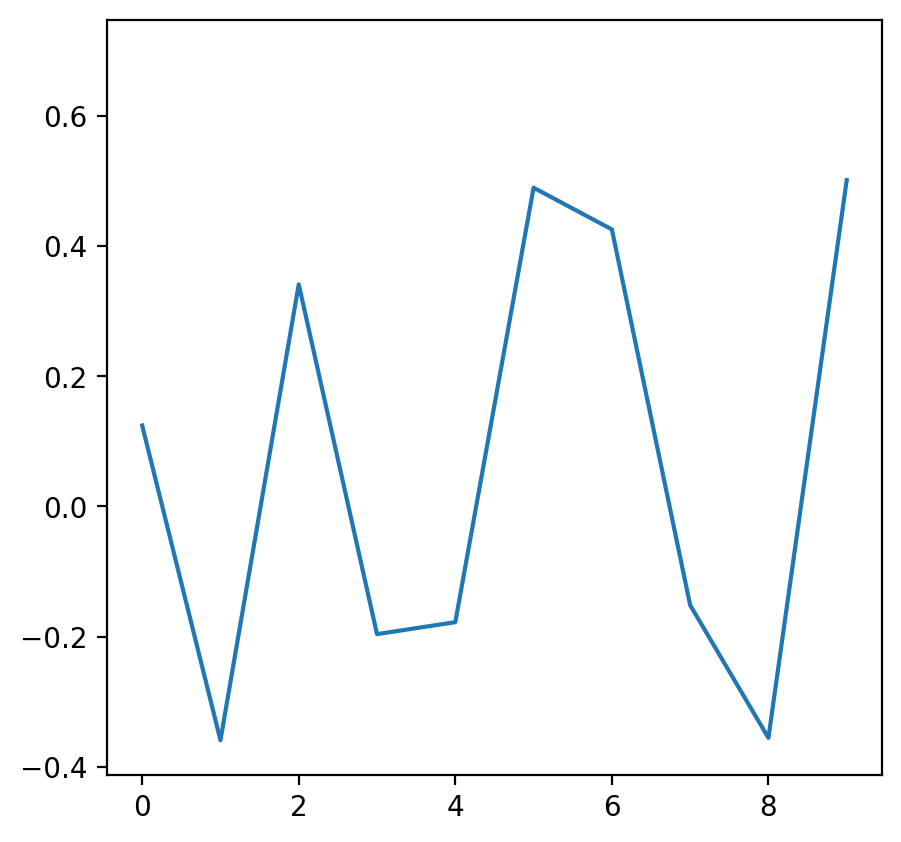

In [115]:
figure = plt.figure(figsize = (5,5), dpi = 200)
for i in range(len(pesos)):
    plt.plot(pesos[i][i][i])